In [1]:
%pylab inline
from pycheops import Dataset, StarProperties
from uncertainties import ufloat
# Temporary(?) fix for problem with coordinate look-up for HD stars in astropy 
from astropy.coordinates.name_resolve import sesame_database
sesame_database.set('simbad');

Populating the interactive namespace from numpy and matplotlib


### Create and instance of the dataset

*Run pycheops.core.setup_config once first to create the configuration file and data cache directory*

```python
>>> from pycheops.core import setup_config
>>> setup_config()
```

This step can be used to download the data from CHEOPsim ftp site using the run number, e.g., 
```python
>>> dataset = Dataset().from_simulation(7649, target='HD97658')
```

The cached version is then loaded using the program number, e.g., 
```python
>>> dataset = Dataset('PR900048_TG001501')
```

The lightcurve for analysis is then selected using the get_lightcurve method. 


In [2]:
dataset = Dataset().from_simulation(7649, target='HD97658')
#dataset = Dataset('PR900048_TG001501')
_ = dataset.get_lightcurve(aperture='OPTIMAL')

/Users/pflm/pycheops_data/CH_PR900048_TG001501.zip already downloaded
Writing Imagette data to .tgz file...
Writing Lightcurve data to .tgz file...
.. CH_PR900048_TG001501_TU2020-04-03T04-11-52_SCI_COR_Lightcurve-DEFAULT_V0000.fits - done
.. CH_PR900048_TG001501_TU2020-04-03T04-11-52_SCI_COR_Lightcurve-OPTIMAL_V0000.fits - done
.. CH_PR900048_TG001501_TU2020-04-03T04-11-52_SCI_COR_Lightcurve-RINF_V0000.fits - done
.. CH_PR900048_TG001501_TU2020-04-03T04-11-52_SCI_COR_Lightcurve-RSUP_V0000.fits - done
Found archive tgzfile /Users/pflm/pycheops_data/PR900048_TG001501.tgz
 PI name     : CHEOPSim
 OBS ID      : 7649
 Target      : HD97658
 Coordinates : 11:14:33.16 +25:42:37.4
Light curve data loaded from  /Users/pflm/pycheops_data/PR900048_TG001501-OPTIMAL.fits
C_cut = 97317724
N(C > C_cut) = 0
Mean counts = 97182778.5
Median counts = 97196778.9
RMS counts = 39092.5 [402 ppm]
Median standard error = 97196778.9 [104 ppm]


### Estimate stellar density and limb darkening from parameers in SWEET-Cat 

Prior on mean stellar density is helpful to constrain the width of the eclipse.

In [3]:
pHD97658 = StarProperties(dataset.target)
print(pHD97658)
logrhoprior = pHD97658.logrho
# logrhoprior = ufloat(0.0593, 0.1556) # for offline user

Identifier : HD97658
Coordinates: 11:14:33.16 +25:42:37.4
T_eff :  5137 +/- 36 K
log g :  4.47 +/- 0.09 [cgs]
[M/H] : -0.35 +/- 0.02
log rho :  0.06 +/- 0.16 [solar]
h_1 : 0.708 +/- 0.010
h_2 : 0.439 +/- 0.051



### Least-squares fit

Light curve for a planet of radius $R_p$ transiting a star of radius $R_s$ with impact parameter $b$ is calculated using the power-2 limb-darkening law, 
$$I_{\lambda}(\mu) = 1 - c(1 - \mu^{\alpha}),$$
and is described by the following parameters.

- T_0:   time of mid-transit
- P:     orbital period
- D:     depth, $(R_p/R_s)^2 = k^2$
- W:     width, $(R_s/a)\sqrt{(1+k)^2 - b^2}/\pi$
- S:     shape, $[(1-k)^2-b^2]/[(1+k)^2 - b^2]$
- c:     flux scaling factor
- f_c:   $\sqrt{e}\cos(\omega)$
- f_s:   $\sqrt{e}\sin(\omega)$
- h_1:   $I_{\lambda}(0.5) = 1 - c(1-2^{-\alpha})$
- h_2:   $I_{\lambda}(0.5) - I_{\lambda}(0) = c\cdot2^{-\alpha}$

Model options available here are 
 - linear or quadratic decorrelation against position (dfdx, dfdy, df2dx2, d2fdxdy, d2fdx2, d2fdy2)
 - linear decorrelation against roll angle (dfdsinphi, dfdcosphi)
 - linear or quadratic time trend (dfdt, d2fdt2)
 
The stellar density can be included as a prior in the least-squares fit using the keyword logrhoprior.

Parameters and their bounds/priors are  specified as follows.

- as a floating point number for fixed parameters, e.g., "P=1.234".
- as a tuple for a free parameter with bounds, e.g., "h_2 = (0.3,0.7)" or "c = (0.9, 1.0, 1.1)". The median value of the tuple is used as the initial value in the fit.
- as a ufloat floating-point value with a standard error, e.g., "P=ufloat(1.2345,0.0001)", to specify a free parameter with a Gaussian prior.
- as an lmfit Parameter, e.g., "lmfit.Parameter(value=0.01,min=0.001,max=0.1,vary=True)"

The output from this method is an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) object.

The limb-darkening is not well constrained by this light curve so we fix the parameter h_2 at its nominal value (".n") and fit the parameter h_1 with a prior.
 

In [4]:
result = dataset.lmfit_transit(P=ufloat(9.489264,0.00001), T_0=ufloat(0.890,0.001),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n,
                              logrhoprior=logrhoprior)
print(dataset.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 580
    # variables        = 7
    chi-square         = 1534.45546
    reduced chi-square = 2.67793274
    Akaike info crit   = 578.283592
    Bayesian info crit = 608.824789
[[Variables]]
    T_0:     0.89055878 +/- 4.4763e-04 (0.05%) (init = 0.89)
    P:       9.48926400 +/- 1.6364e-05 (0.00%) (init = 9.489264)
    D:       7.4000e-04 +/- 6.6703e-05 (9.01%) (init = 0.001244335)
    W:       0.01426471 +/- 1.4973e-04 (1.05%) (init = 0.02208278)
    S:       0.87971847 +/- 0.04220332 (4.80%) (init = 0.8283019)
    f_c:     0 (fixed)
    f_s:     0 (fixed)
    h_1:     0.70028168 +/- 0.01532240 (2.19%) (init = 0.708)
    h_2:     0.439 (fixed)
    c:       1.00009341 +/- 8.5132e-06 (0.00%) (init = 1)
    k:       0.02720288 +/- 0.00122603 (4.51%) == 'sqrt(D)'
    bsq:     0.15050533 +/- 0.31741224 (210.90%) == '((1-k)**2-S*(1+k)**2)/(1-S)'
    b:       0.38795017 +/- 0.40908893 (105

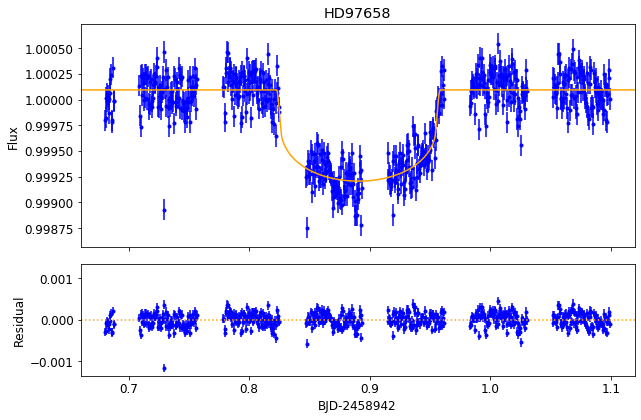

In [5]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12)
fig.savefig("HD97658_lmfit.eps")

### Sampling the posterior
Sampling the posterior probability distribution using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

*Using a much lower number of burn-in and sampling steps here than would normally be used - just to see how it works*

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

In [6]:
sampler = dataset.emcee_transit(burn=32, steps=32, nwalkers=32, thin=4)
print(dataset.emcee_report())

Running burn-in ..


 50%|█████     | 16/32 [00:02<00:02,  7.06it/s]/Users/pflm/anaconda3/lib/python3.7/site-packages/asteval/asteval.py:776: RuntimeWarning: invalid value encountered in sqrt
  return func(*args, **keywords)
100%|██████████| 32/32 [00:04<00:00,  7.03it/s]

Running sampler ..



100%|██████████| 128/128 [00:18<00:00,  7.07it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 4096
    # data points      = 576
    # variables        = 8
    chi-square         = 1537.41443
    reduced chi-square = 2.70671554
    Akaike info crit   = -8352.22281
    Bayesian info crit = -8317.37395
[[Variables]]
    T_0:        0.89102972 +/- 5.2278e-04 (0.06%) (init = 0.89)
    P:          9.48924895 +/- 8.1155e-06 (0.00%) (init = 9.489264)
    D:          8.0593e-04 +/- 5.3491e-05 (6.64%) (init = 0.001244335)
    W:          0.01426424 +/- 1.5403e-04 (1.08%) (init = 0.02208278)
    S:          0.83270305 +/- 0.04149386 (4.98%) (init = 0.8283019)
    f_c:        0 (fixed)
    f_s:        0 (fixed)
    h_1:        0.69785553 +/- 0.00932562 (1.34%) (init = 0.708)
    h_2:        0.439 (fixed)
    c:          1.00009784 +/- 6.1286e-06 (0.00%) (init = 1)
    k:          0.02838899 +/- 0.00122603 (4.32%) == 'sqrt(D)'
    bsq:        0.37881499 +/- 0.31741224 (83.79%) == '((1-k)**2-S*(1+k)**2)/(1-S)'
    b: 

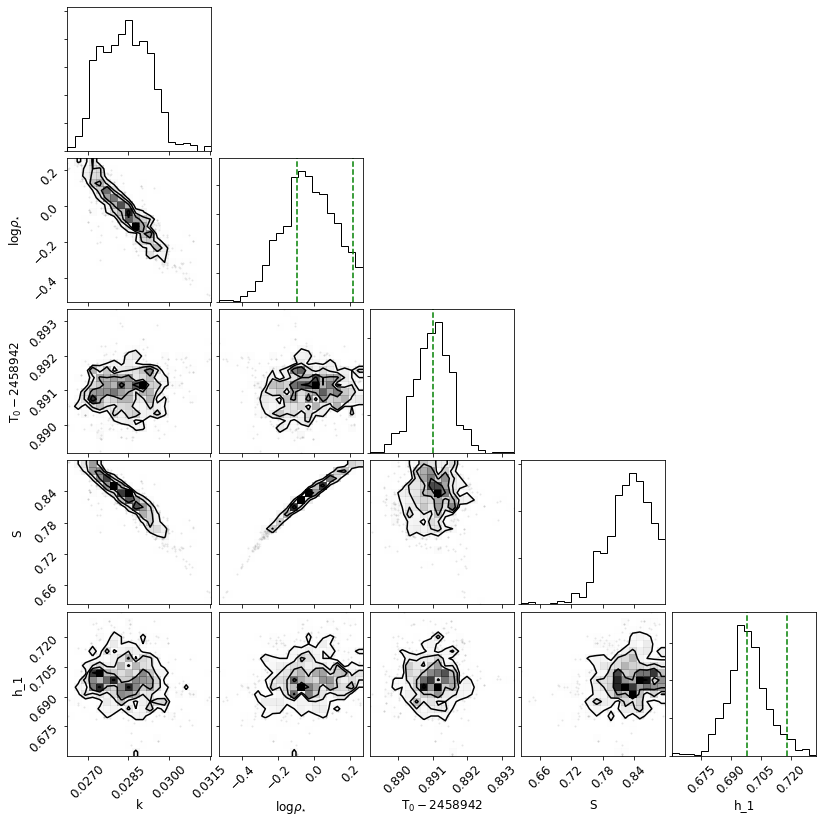

In [7]:
cornerplot = dataset.corner_plot(['k','logrho','T_0','S','h_1'])

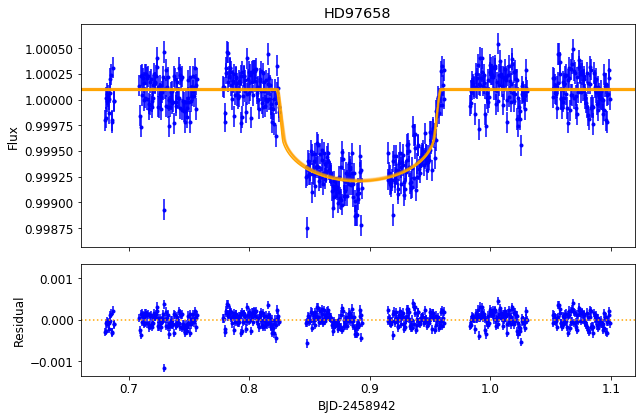

In [8]:
fig = dataset.plot_emcee(title=dataset.target,figsize=(9,6),fontsize=12)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/). By default the parameter quality factor is fixed at $Q=1/\sqrt{2}$ so that the kernel is the one commonly used to model granulation noise
$$ k(\tau) = \omega_0 e^{-\omega_0\tau/\sqrt{2}}\cos\left(-\omega_0\tau/\sqrt{2} - \pi/4\right)$$

In [9]:
sampler = dataset.emcee_transit(add_shoterm=True, burn=128, steps=64, nwalkers=64, thin=4)
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 128/128 [00:39<00:00,  3.20it/s]

Running sampler ..



100%|██████████| 256/256 [01:18<00:00,  3.35it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 16384
    # data points      = 576
    # variables        = 10
    chi-square         = 1579.16358
    reduced chi-square = 2.79004167
    Akaike info crit   = -8343.27088
    Bayesian info crit = -8299.70981
[[Variables]]
    T_0:         0.89092681 +/- 5.8843e-04 (0.07%) (init = 0.89)
    P:           9.48926165 +/- 1.1423e-05 (0.00%) (init = 9.489264)
    D:           8.2969e-04 +/- 9.8298e-05 (11.85%) (init = 0.001244335)
    W:           0.01439629 +/- 1.7263e-04 (1.20%) (init = 0.02208278)
    S:           0.83398169 +/- 0.03401786 (4.08%) (init = 0.8283019)
    f_c:         0 (fixed)
    f_s:         0 (fixed)
    h_1:         0.70162736 +/- 0.01243761 (1.77%) (init = 0.708)
    h_2:         0.439 (fixed)
    c:           1.00008598 +/- 2.4863e-05 (0.00%) (init = 1)
    k:           0.02880439 +/- 0.00122603 (4.26%) == 'sqrt(D)'
    bsq:         0.36443327 +/- 0.31741224 (87.10%) == '((1-k)**2-S*(1+k)**2)

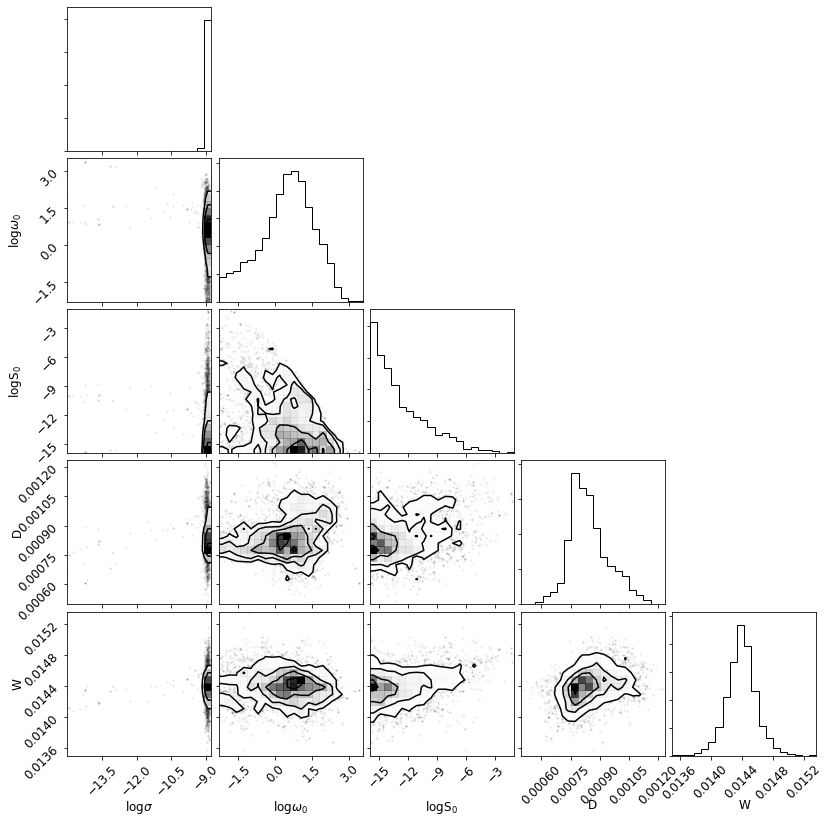

In [10]:
cornerplot = dataset.corner_plot(['log_sigma','log_omega0','log_S0','D','W'])

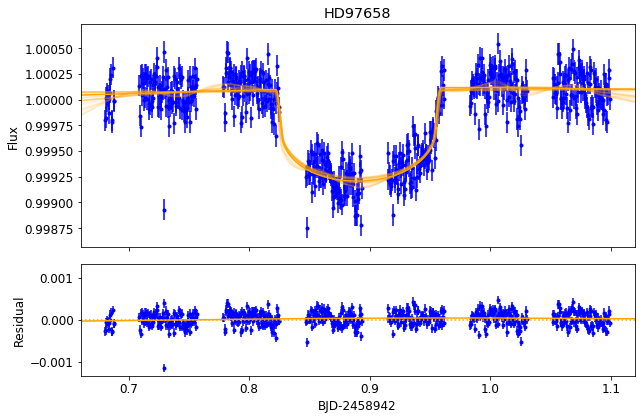

In [11]:
fig = dataset.plot_emcee(title=dataset.target,figsize=(9,6),fontsize=12)

(c) 2019 Pierre Maxted, Keele Univerity, UK